<a href="https://colab.research.google.com/github/macbhaldar/Data-Science-Python-Handbook/blob/main/Logistic-Regression/Logistic_Regression_Banking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

The dataset provides the bank customers’ information. It includes 17688 records and 21 fields.

In [5]:
data = pd.read_csv('banking.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(26534, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


In [6]:
# The education column of the dataset has many categories and we need to reduce the categories for a better modelling.
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [7]:
# Let us group “basic.4y”, “basic.9y” and “basic.6y” together and call them “basic”.
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [8]:
data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

### Data Exploration

In [9]:
data['y'].value_counts()

0.0    23479
1.0     3055
Name: y, dtype: int64

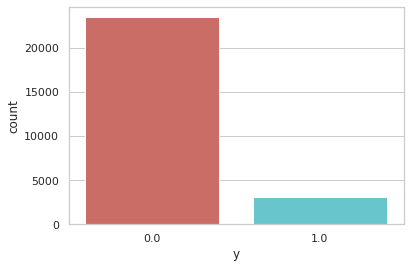

<Figure size 432x288 with 0 Axes>

In [10]:
sns.countplot(x='y', data=data, palette='hls')
plt.show()
plt.savefig('count_plot')

In [11]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.48647018919122
percentage of subscription 11.513529810808773


Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 89:11.

In [12]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0.0,39.910899,219.470080,2.635887,984.543890,0.133907,0.251480,93.606358,-40.573044,3.814634,5176.192334
1.0,40.701146,556.452046,2.031097,790.950573,0.487070,-1.213552,93.370053,-39.887496,2.135008,5095.507660


#### Observations:
- The average age of customers who bought the term deposit is higher than that of the customers who didn’t.
- The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.
- Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

calculate categorical means for other categorical variables such as education and marital status

In [13]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.102288,254.599970,2.608644,955.500224,0.190070,0.016704,93.537921,-40.280888,3.548575,5163.958576,0.134141
blue-collar,39.451656,263.929575,2.554868,985.552191,0.122449,0.258782,93.663685,-41.370492,3.780809,5175.921646,0.069254
entrepreneur,41.673913,268.369565,2.594203,978.430642,0.138716,0.169462,93.607479,-41.126812,3.813107,5176.360145,0.097308
housemaid,45.519882,254.412371,2.652430,966.823270,0.110457,0.462150,93.687080,-39.591458,4.040230,5181.219293,0.092784
management,42.387181,255.921313,2.512246,958.627931,0.195414,-0.030328,93.525875,-40.490620,3.582950,5165.397134,0.113080
retired,62.127949,279.692377,2.419238,901.634301,0.331216,-0.723049,93.426040,-38.458439,2.748401,5120.965517,0.255898
self-employed,39.934479,262.816327,2.664876,976.586466,0.160043,0.072932,93.546426,-40.478518,3.681635,5170.399785,0.099893
services,37.913113,259.732961,2.601435,979.998007,0.153846,0.216660,93.651030,-41.199083,3.740602,5172.803308,0.086887
student,25.922261,273.491166,2.090106,837.747350,0.531802,-1.430035,93.340569,-40.334276,1.847788,5083.823675,0.328622


In [14]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.789350,252.319178,2.578362,967.867206,0.175261,0.142602,93.602852,-40.773441,3.692073,5169.991304,0.103134
married,42.281954,257.914499,2.581643,967.917735,0.156067,0.188768,93.602131,-40.253304,3.750339,5171.939371,0.103547
single,33.172687,261.211763,2.523029,947.949644,0.213509,-0.166873,93.520881,-40.898738,3.317179,5154.886263,0.144756
unknown,40.240000,286.760000,3.340000,939.580000,0.280000,-0.336000,93.465700,-41.050000,3.217640,5154.556000,0.140000


In [15]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.131010,262.219627,2.555803,976.299716,0.141762,0.194661,93.644792,-40.893141,3.736538,5172.081016,0.087134
high.school,37.966776,263.164803,2.576645,964.880592,0.184375,0.049507,93.592977,-40.895576,3.571425,5165.295493,0.112664
illiterate,47.083333,247.583333,2.416667,999.000000,0.083333,0.225000,93.433583,-42.450000,3.839083,5187.775000,0.166667
professional.course,40.057278,255.692058,2.596988,959.743136,0.160319,0.179097,93.571147,-40.143608,3.714380,5170.538028,0.118984
university.degree,38.895226,250.772120,2.555824,950.056015,0.198218,-0.043806,93.492923,-39.988224,3.510297,5162.305716,0.140038
unknown,43.218215,263.681695,2.567178,939.059513,0.237151,0.050406,93.661212,-40.014427,3.552376,5159.165555,0.144274


### Visualizations

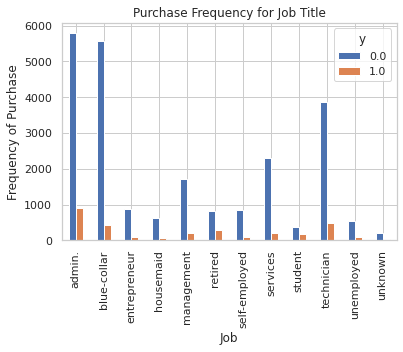

In [16]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

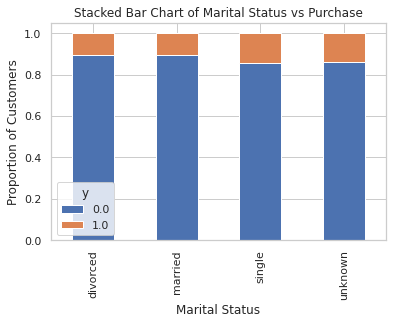

In [17]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

The marital status does not seem a strong predictor for the outcome variable.

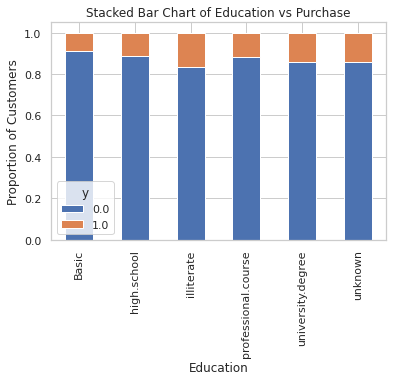

In [18]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

Education seems a good predictor of the outcome variable.

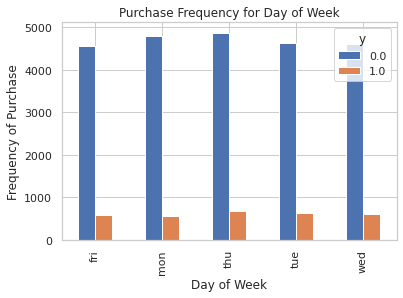

In [19]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_dayofweek_bar')

Day of week may not be a good predictor of the outcome.

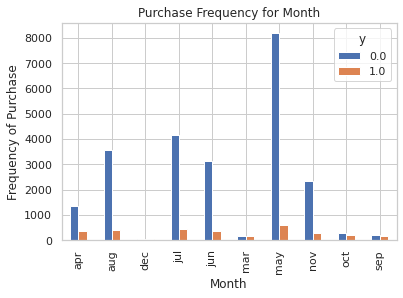

In [20]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')

Month might be a good predictor of the outcome variable.

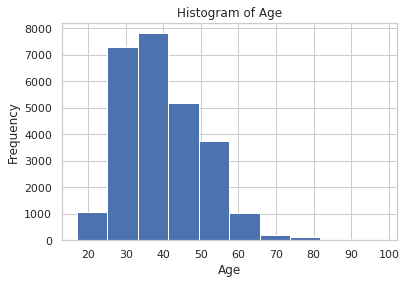

In [21]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

Most of the customers of the bank in this dataset are in the age range of 30–40.

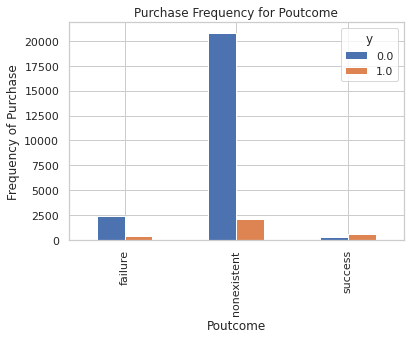

In [22]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

Poutcome seems to be a good predictor of the outcome variable.

### Create dummy variables
That is variables with only two values, zero and one.

In [23]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [24]:
# Our final data columns will be:
data_final=data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

### Over-sampling using SMOTE
With our training data created, I’ll up-sample the no-subscription using the SMOTE algorithm(Synthetic Minority Oversampling Technique). At a high level, SMOTE:
1. Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
2. Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [25]:
pip install imblearn

In [26]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  32846
Number of no subscription in oversampled data 16423
Number of subscription 16423
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


Now we have a perfect balanced data! You may have noticed that I over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

### Recursive Feature Elimination

In [27]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

In [28]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

TypeError: ignored

In [29]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 'default_no', 'default_unknown', 
      'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

### Implementing the model

In [31]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.449604
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.351     
Dependent Variable:   y                 AIC:               29575.3880
Date:                 2022-03-17 07:57  BIC:               29743.3797
No. Observations:     32846             Log-Likelihood:    -14768.   
Df Model:             19                LL-Null:           -22767.   
Df Residuals:         32826             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m             0.1635   0.0100  16.4080 0.0000  0.1440  0.1831
job_blue-collar 

The p-values for most of the variables are smaller than 0.05, except one variables, therefore, we will remove them.

In [32]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'default_no', 'default_unknown', 'contact_cellular', 'contact_telephone', 
      'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.449608
         Iterations 7
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.351     
Dependent Variable:  y                AIC:              29573.6582
Date:                2022-03-17 07:57 BIC:              29733.2503
No. Observations:    32846            Log-Likelihood:   -14768.   
Df Model:            18               LL-Null:          -22767.   
Df Residuals:        32827            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      7.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
euribor3m          0.1635   0.0100  16.4068 0.0000  0.1440  0.1830
job_blue-collar   -1.0755   0.0488 -22.0423 0.0000 -1

### Logistic Regression Model Fitting

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

#### Predicting the test set results and calculating the accuracy

In [34]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.87


### Confusion Matrix

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[4492  428]
 [ 827 4107]]


The result is telling us that we have 4492+4104 correct predictions and 428+827 incorrect predictions.

### Compute precision, recall, F-measure and support

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.91      0.88      4920
         1.0       0.91      0.83      0.87      4934

    accuracy                           0.87      9854
   macro avg       0.88      0.87      0.87      9854
weighted avg       0.88      0.87      0.87      9854



Interpretation: Of the entire test set, 87% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 783 of the customer’s preferred term deposits that were promoted.

### ROC Curve

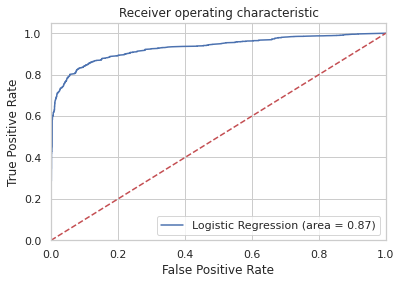

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()